<a href="https://colab.research.google.com/github/jumbokh/Intelligent-monitoring-class/blob/main/notebooks/CH25_%E5%8F%A3%E7%BD%A9%E5%88%A4%E6%96%B7%E6%A8%A1%E5%9E%8B%E4%B9%8B%E8%B3%87%E6%96%99%E9%9B%86%E7%9A%84%E6%BA%96%E5%82%99.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 匯入套件

In [1]:
import matplotlib.pyplot as plt
import os,cv2,shutil
import math
import numpy as np
import json

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -fs /content/gdrive/My\ Drive /app

Mounted at /content/gdrive


In [3]:
!ls /app/cuDNN

cuda_10.1.105_418.96_win10.zip	cuda_11.4.2_win10_network.zip
cuda-10.2-win10.zip		cudnn-10.0-linux-x64-v7.5.0.56.tgz


In [4]:
!tar -xzvf /app/cuDNN/cudnn-10.0-linux-x64-v7.5.0.56.tgz -C /usr/local/
!chmod a+r /usr/local/cuda/include/cudnn.h

# 檢查是否安裝成功
!cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2

cuda/include/cudnn.h
cuda/NVIDIA_SLA_cuDNN_Support.txt
cuda/lib64/libcudnn.so
cuda/lib64/libcudnn.so.7
cuda/lib64/libcudnn.so.7.5.0
cuda/lib64/libcudnn_static.a
#define CUDNN_MAJOR 7
#define CUDNN_MINOR 5
#define CUDNN_PATCHLEVEL 0
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


# 讀取口罩圖片

In [6]:
mask_img_dir = r"/app/data/RGBA_PNG_masks"
# mask_img_dir = r"drive/MyDrive/Python/Code/Jupyter/Book/RGBA_PNG_masks"
mask_paths = [file.path for file in os.scandir(mask_img_dir) if file.name.split(".")[-1] == 'png']
qty_mask_img = len(mask_paths)
print(qty_mask_img)

34


In [7]:
#----randum mask png 
mask_num = np.random.randint(qty_mask_img)
img_mask_ori = cv2.imread(mask_paths[mask_num],cv2.IMREAD_UNCHANGED)
print(img_mask_ori.shape)

(506, 728, 4)


Text(0.5, 1.0, 'Alpha channel')

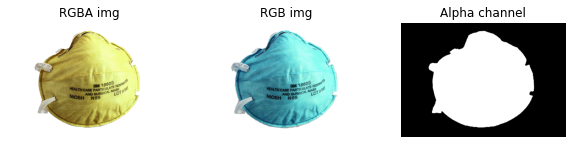

In [8]:
img_mask_bgr = img_mask_ori[:, :, :3]

img_alpha_ch = img_mask_ori[:, :, 3]

_, item_mask = cv2.threshold(img_alpha_ch, 220, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plt.imshow(img_mask_ori)
plt.axis('off')
plt.title('RGBA img')

plt.subplot(1,3,2)
plt.imshow(img_mask_bgr[:,:,::-1])
plt.axis('off')
plt.title('RGB img')


plt.subplot(1,3,3)
plt.imshow(item_mask,cmap='gray')
plt.axis('off')
plt.title('Alpha channel')

# DLIB初始化

In [9]:
import dlib
# ----Dlib init
# predictor_path = r"drive/MyDrive/Python/Code/Jupyter/Book/CH25/shape_predictor_68_face_landmarks.dat"
predictor_path = "/app/data/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

# 使用Dlib找到人臉

faces: rectangles[[(67, 80) (175, 187)]]
scores: [1.018491093112361]
idx: [0]


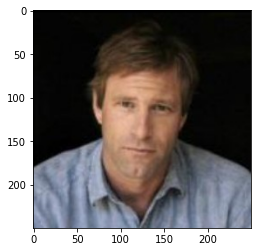

In [11]:
path = r"/app/data/Aaron_Eckhart_0001.jpg"

img = cv2.imread(path)
if img is None:
    print("Read failed:{}".format(path))
else:
    faces, scores, idx = detector.run(img, 1)
    
    print("faces:",faces)#人臉區域的座標
    print("scores:",scores)
    print("idx:",idx)
    
    plt.imshow(img[:,:,::-1])

# 使用方框畫出人臉部分

1.018491093112361
0


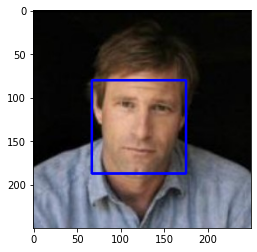

In [12]:
# path = r"D:\dataset\lfw_1\Aaron_Eckhart\Aaron_Eckhart_0001.jpg"

img = cv2.imread(path)
if img is None:
    print("Read failed:{}".format(path))
else:
    faces, scores, idx = detector.run(img, 1)
    if len(faces):
        for i,d in enumerate(faces):
            
            cv2.rectangle(img, (d.left(), d.top()), (d.right(), d.bottom()),
                         (255,0,0),2)
            
            print(scores[i])
            print(idx[i])
             
    plt.imshow(img[:,:,::-1])

    plt.show()     

# 加上margin

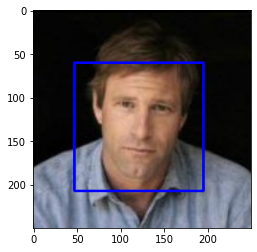

In [13]:
# path = r"F:\dataset\LFW\ori\Aaron_Eckhart\Aaron_Eckhart_0001.jpg"
margin = 40

img = cv2.imread(path)
if img is None:
    print("Read failed:{}".format(path))
else:
    faces, scores, idx = detector.run(img, 1)
    if len(faces):
        for i,d in enumerate(faces):
            x_min = max((d.left() - margin // 2),0)
            y_min = max((d.top() - margin // 2),0)
            x_max = min((d.right() + margin // 2),img.shape[1])
            y_max = min((d.bottom() + margin // 2),img.shape[0])
            
            cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255,0,0),2)
             
    plt.imshow(img[:,:,::-1])

    plt.show()     

# 顯示人臉的68個標註點

1.018491093112361
0


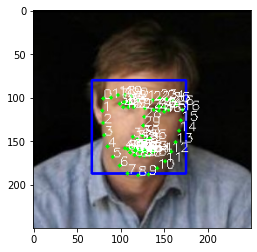

In [14]:
# path = r"F:\dataset\LFW\ori\Aaron_Eckhart\Aaron_Eckhart_0001.jpg"

img = cv2.imread(path)
if img is None:
    print("Read failed:{}".format(path))
else:
    faces, scores, idx = detector.run(img, 1)
    if len(faces):
        for i,d in enumerate(faces):
            
            #cv2.rectangle(影像, 左上點座標,右下點座標, 顏色, 線條寬度)
            cv2.rectangle(img, (d.left(), d.top()), (d.right(), d.bottom()), (255,0,0),2)
            
            print(scores[i])
            print(idx[i])
            
            #----畫上68個標註點
            shape = predictor(img, d)
            for i in range(68):
                #cv2.circle(影像, 圓心座標, 半徑, 顏色, 線條寬度)
                cv2.circle(img, (shape.part(i).x, shape.part(i).y), 2, (0, 255, 0), -1, 8)
                #cv2.putText(影像, 文字, 座標, 字型, 大小, 顏色, 線條寬度, 線條種類)
                cv2.putText(img, str(i), (shape.part(i).x, shape.part(i).y), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                            (255, 2555, 255))   
    plt.imshow(img[:,:,::-1])

    plt.show()
            

# 框出嘴巴部分

In [15]:
def mouth_detection(img,predictor,d):
    #----算出臉部區域的高度與寬度
    face_height = d.bottom() - d.top()
    face_width = d.right() - d.left()
    
    #----得到68個標註點
    shape = predictor(img, d)

    #----get the mouth part
    x = list()#用來蒐集所有的X座標
    y = list()#用來蒐集所有的Y座標

    for i in range(48, 68):#48~68是嘴部區域的標註點
        x.append(shape.part(i).x)#蒐集所有的X座標
        y.append(shape.part(i).y)#蒐集所有的Y座標
    
    #----增加嘴部區域
    height_margin = face_height // 3
    width_margin = face_width // 3

    y_max = min((max(y) + height_margin),img.shape[0])
    y_min = max((min(y) - height_margin),0)
    x_max = min((max(x) + width_margin),img.shape[1])
    x_min = max((min(x) - width_margin),0)
    
    return (x_min,y_min), (x_max,y_max) 

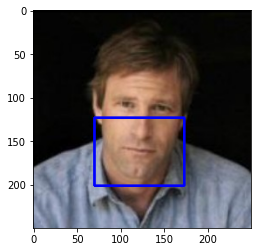

In [16]:
# path = r"F:\dataset\LFW\ori\Aaron_Eckhart\Aaron_Eckhart_0001.jpg"

img = cv2.imread(path)
if img is None:
    print("Read failed:{}".format(path))
else:
    faces, scores, idx = detector.run(img, 0)
    
    if len(faces):
        for i,d in enumerate(faces):
            #----找到嘴巴部分
            (x_min,y_min), (x_max,y_max) = mouth_detection(img,predictor,d)
           
            cv2.rectangle(img, (x_min,y_min), (x_max, y_max), (255,0,0),2)
        
        plt.imshow(img[:,:,::-1])
        
        plt.show()

# 嘴部區域與口罩整合

In [17]:
# path = r"F:\dataset\LFW\ori\Aaron_Eckhart\Aaron_Eckhart_0001.jpg"

img = cv2.imread(path)
if img is None:
    print("Read failed:{}".format(path))
else:
    faces, scores, idx = detector.run(img, 0)
    
    if len(faces):
        for i,d in enumerate(faces):
            #----找到嘴巴部分
            (x_min,y_min), (x_max,y_max) = mouth_detection(img,predictor,d)
            
            #----亂數取一張口罩圖片
            mask_path = np.random.choice(mask_paths)
            img_mask_ori = cv2.imread(mask_path,cv2.IMREAD_UNCHANGED)

            #----口罩PNG圖片的處理
            size = ((x_max-x_min),(y_max-y_min))#嘴部區域的高度與寬度
            img_mask = cv2.resize(img_mask_ori, size)#口罩大小調整與嘴部區域相同
            img_mask_bgr = img_mask[:, :, :3]#取出口罩BGR資料
            img_alpha_ch = img_mask[:, :, 3]#取出口罩Alpha資料
            
            #----口罩圖片的遮罩(讓口罩部分數值皆為255，其餘為0)
            _, item_mask = cv2.threshold(img_alpha_ch, 220, 255, cv2.THRESH_BINARY)
            
            #----嘴部圖片的遮罩(讓嘴部數值皆為0，其餘為255)
            human_mask = cv2.bitwise_not(item_mask)#與口罩遮罩內容相反

            img_with_mask = img.copy()#不能只有 =img，否則img也會一起戴上口罩
            mouth_part = img_with_mask[y_min:y_max, x_min:x_max]#取出嘴部區域
            
            #----進行遮罩比對
            img_item_part = cv2.bitwise_and(img_mask_bgr, img_mask_bgr, mask=item_mask)
            img_human_part = cv2.bitwise_and(mouth_part, mouth_part, mask=human_mask)
            
            #----嘴部與口罩相加
            dst = cv2.add(img_human_part, img_item_part)
            img_with_mask[y_min: y_min + size[1], x_min:x_min + size[0]] = dst

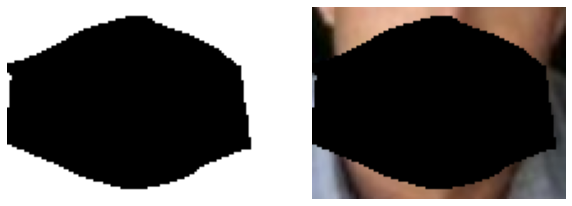

In [18]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(human_mask,cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_human_part[:,:,::-1])
plt.axis('off')

plt.show()

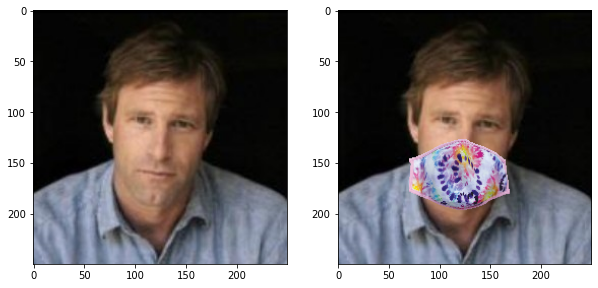

In [19]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img[:,:,::-1])

plt.subplot(1,2,2)
plt.imshow(img_with_mask[:,:,::-1])

plt.show()

# 製作訓練集

In [ ]:
img_dir = r"F:\dataset\CASIA\CASIA-WebFace"
save_dir = r"F:\dataset\face_mask\train_set"
select_num = 10000
margin = 30
size = (80,80)
paths = list()

#----蒐集所有的圖片路徑
for dir_name,sub_dir_list,filename_list in os.walk(img_dir):
    if len(filename_list) > 0:
        for filename in filename_list:
            path = os.path.join(dir_name,filename)
            paths.append(path)

#----shuffle
np.random.shuffle(paths)

In [ ]:
for idx_path in range(select_num):
    path = paths[idx_path]
    img = cv2.imread(path)
    if img is None:
        print("Read failed:{}".format(path))
    else:
        faces, scores, idx = detector.run(img, 0)
        if len(faces):
            for i,d in enumerate(faces):
                x_min = max((d.left() - margin // 2),0)
                y_min = max((d.top() - margin // 2),0)
                x_max = min((d.right() + margin // 2),img.shape[1])
                y_max = min((d.bottom() + margin // 2),img.shape[0])
                
                #----人臉的尺寸都要在80以上
                if y_max - y_min >= 80 and x_max - x_min >= 80:
                    #----取出臉部區域
                    face_part = img[y_min:y_max,x_min:x_max,:]
                    #----resize圖片大小
                    face_part = cv2.resize(face_part,size)
                    #----使用idx_path, i來當作檔名
                    #----使用png是因為不會壓縮圖片，破壞品質
                    filename = "{}_{}.png".format(str(idx_path),str(i))
                    new_path = os.path.join(save_dir,filename)
                    cv2.imwrite(new_path,face_part)
        else:
            print("No mouth detected")

No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth d

No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth d

No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth detected
No mouth d

# 製作驗證集(沒有戴口罩)

In [ ]:
img_dir = r"F:\dataset\LFW\ori"
output_dir = r"F:\dataset\face_mask\test_set\no_mask"
size = (80,80)
margin = 30
paths = list()

#----蒐集所有的圖片路徑
for dir_name,sub_dir_list,filename_list in os.walk(img_dir):
    if len(filename_list) > 0:
        for filename in filename_list:
            path = os.path.join(dir_name,filename)
            paths.append(path)
qty = len(paths)
print(qty)

for idx_path in range(qty):
    path = paths[idx_path]
    img = cv2.imread(path)
    if img is None:
        print("Read failed:{}".format(path))
    else:
        faces, scores, idx = detector.run(img, 0)
        if len(faces):
            for i,d in enumerate(faces):
                x_min = max((d.left() - margin // 2),0)
                y_min = max((d.top() - margin // 2),0)
                x_max = min((d.right() + margin // 2),img.shape[1])
                y_max = min((d.bottom() + margin // 2),img.shape[0])
                
                #----save images without masks
                face_part = img.copy()
                face_part = face_part[y_min:y_max,x_min:x_max,:]
                face_part = cv2.resize(face_part,size)
                filename = "{}_{}.png".format(str(idx_path),str(i))
                new_path = os.path.join(output_dir,filename)
                cv2.imwrite(new_path,face_part)

13233


# 製作驗證集(有戴口罩)

In [ ]:
img_dir = r"F:\dataset\face_mask\test_set\no_mask"
output_dir = r"F:\dataset\face_mask\test_set\with_mask"
paths = [file.path for file in os.scandir(img_dir) if file.name.split(".")[-1] == 'png']

qty = len(paths)
print(qty)

for idx_path,path in enumerate(paths):
    img = cv2.imread(path)
    if img is None:
        print("Read failed:{}".format(path))
    else:
        faces, scores, idx = detector.run(img, 0)

        if len(faces):
            for i,d in enumerate(faces):
                #----找到嘴巴部分
                (x_min,y_min), (x_max,y_max) = mouth_detection(img,predictor,d)

                #----亂數取一張口罩圖片
                mask_path = np.random.choice(mask_paths)
                img_mask_ori = cv2.imread(mask_path,cv2.IMREAD_UNCHANGED)

                #----口罩PNG圖片的處理
                size = ((x_max-x_min),(y_max-y_min))#嘴部區域的高度與寬度
                img_mask = cv2.resize(img_mask_ori, size)#口罩大小調整與嘴部區域相同
                img_mask_bgr = img_mask[:, :, :3]#取出口罩BGR資料
                img_alpha_ch = img_mask[:, :, 3]#取出口罩Alpha資料

                #----口罩圖片的遮罩(讓口罩部分數值皆為255，其餘為0)
                _, item_mask = cv2.threshold(img_alpha_ch, 220, 255, cv2.THRESH_BINARY)

                #----嘴部圖片的遮罩(讓嘴部數值皆為0，其餘為255)
                human_mask = cv2.bitwise_not(item_mask)#與口罩遮罩內容相反

                img_with_mask = img.copy()#不能只有 =img，否則img也會一起戴上口罩
                mouth_part = img_with_mask[y_min:y_max, x_min:x_max]#取出嘴部區域

                #----進行遮罩比對
                img_item_part = cv2.bitwise_and(img_mask_bgr, img_mask_bgr, mask=item_mask)
                img_human_part = cv2.bitwise_and(mouth_part, mouth_part, mask=human_mask)

                #----嘴部與口罩相加
                dst = cv2.add(img_human_part, img_item_part)
                img_with_mask[y_min: y_min + size[1], x_min:x_min + size[0]] = dst
                
                #----save images
                filename = "{}_{}.png".format(str(idx_path),str(i))
                new_path = os.path.join(output_dir,filename)
                cv2.imwrite(new_path,img_with_mask)

13859
